# Goal of this notebook

Develop a training loop for finetuning ASR models using TTS loss by recreating RL training found in RL4LMs/rl4lms/envs/text_generation/training_utils.py

```bash
conda activate speller
cd /home/s1785140/rlspeller
```

# automatic reloading magic

In [348]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# imports

In [349]:
import torch
from typing import List, Dict, Tuple, Any
import hyperpyyaml
from tqdm import tqdm
from torchaudio.models.decoder import ctc_decoder
from torch.nn.functional import softmax
import random
from jiwer import cer
import numpy as np
import speechbrain as sb
from IPython.display import Audio
import matplotlib.pyplot as plt
import librosa

## check if gpu available

In [579]:
# print hostname to make sure we are on correct node
disallowed_nodes = ['escience6']
import socket
hostname = socket.gethostname()
print(hostname)
node = hostname.split('.')[0]
if node in disallowed_nodes:
    raise ValueError(f"Running on disallowed node {node}!")

greider.inf.ed.ac.uk


In [580]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()
assert torch.cuda.is_available()

In [581]:
import os
os.getcwd()

'/disk/nfs/ostrom/s1785140/rlspeller'

# HPARAMS

In [582]:
inference_hparams = {
    "sentencepiece_model_path": "/home/s1785140/speechbrain/templates/speech_recognition_CharTokens_NoLM/Tokenizer/save/0_char.model",

    # 'speechbrain_hparams_file': '/home/s1785140/rlspeller/infer_speechbrain_subsampling1x_nowhitespace.yaml',
    'speechbrain_hparams_file': '/home/s1785140/rlspeller/infer_speechbrain_subsampling1x.yaml',
    # 'speechbrain_hparams_file': '/home/s1785140/rlspeller/infer_speechbrain_subsampling2x.yaml',
    # 'speechbrain_hparams_file': '/home/s1785140/rlspeller/infer_speechbrain.yaml', # 4x subsampling

    'sample_rate': 16000,
    
    'enable_dropout': True,
    # 'dropout_p': 0.0, # 0.15 is the default value in speechbrain
    'dropout_p': 0.15, # 0.15 is the default value in speechbrain
    # 'dropout_p': 0.3, # 0.15 is the default value in speechbrain
    # 'dropout_p': 0.5, # 0.15 is the default value in speechbrain
    # 'dropout_p': 0.99, # 0.15 is the default value in speechbrain
}

# TOKENIZER

In [583]:
# load pretrained tokenizer used to tokenizer ASR training inputs 
import sentencepiece as spm 
spm_path = inference_hparams["sentencepiece_model_path"]
sp = spm.SentencePieceProcessor()
sp.load(spm_path)
print(sp.vocab_size())

28


In [584]:
# test tokenizer
s = "hello world my name is jason"
# TODO pass string through text cleaners? 
encoded = sp.EncodeAsIds(s)
assert 0 not in encoded, "tried to encode an unknown character"
print(" ".join(str(idx) for idx in encoded))

1 10 2 12 12 4 1 17 4 9 12 11 1 16 20 1 6 5 16 2 1 7 8 1 26 5 8 4 6


In [585]:
sp.DecodeIds(encoded)

'hello world my name is jason'

# NEW! SIMPLE TOKENIZER

In [586]:
from speechbrain.tokenizers.SimpleTokenizer import SimpleTokenizer

In [587]:
tokenizer = SimpleTokenizer()

In [588]:
text = "hello my name is jason"
text = text.replace(' ', '|')
print(text)
ids = tokenizer.encode_as_ids(text)
ids

hello|my|name|is|jason


[9, 6, 13, 13, 16, 1, 14, 26, 1, 15, 2, 14, 6, 1, 10, 20, 1, 11, 2, 20, 16, 15]

In [589]:
tokenizer.decode_ids(ids)

'hello|my|name|is|jason'

## test simple tokenizer with probability distribution, and see if CTC decoder successfully generates n-best lists

In [590]:
# create empty array of correct dimensions
min_len, max_len = 50, 100
bsz = 4
lens = torch.randint(min_len, max_len, (bsz,))
vocab_size = len(tokenizer.vocab)

# randomly assign probaility distribution to each timestep

# try to decode

In [591]:
randn = torch.randn(bsz, max_len, vocab_size)

In [592]:
ctc_probs = softmax(randn, dim=1)
# ctc_probs

In [593]:
ctc_beamsearch_decoder_test = ctc_decoder(
    lexicon=None,
    # tokens="/home/s1785140/rlspeller/templates/speech_recognition_CharTokens_NoLM/Tokenizer/save/tokens.txt",
    tokens=tokenizer.vocab,
    nbest=2,
    blank_token='-',
    sil_token="|",
)

predicted_ids = ctc_beamsearch_decoder_test(ctc_probs, lens)

predicted_words = []
for i, hyps in enumerate(predicted_ids):
    for j, hyp in enumerate(hyps):
        words = tokenizer.decode_ids(hyp.tokens.tolist()).split(" ")
        tup = (f"sample {i+1}, hyp {j+1}/{len(hyps)}", words)
        predicted_words.append(tup)
        print(tup)

('sample 1, hyp 1/2', ['|vkqt|rhomzwbxsqlvplafueuxvqdcoa|cle|jcipfqphdxekxbqjbkumlejepeldv|'])
('sample 1, hyp 2/2', ['|vkqt|rhomzwbxsqlvplafdeuxvqdcoa|cle|jcipfqphdxekxbqjbkumlejepeldv|'])
('sample 2, hyp 1/2', ['|ypqhtwfifgninp|qy|vnptqjqormufu|xsdfkaljybmsamfzymedqe|'])
('sample 2, hyp 2/2', ['|ypqhtwfifgninp|qy|vnptqjqormufu|xsdfkaljybmjamfzymedqe|'])
('sample 3, hyp 1/2', ['|lyaxs|rqpdsnwsifnzovhbqzixcpwkmvykoljzbywbhcurdnwfdwkoaofuarxs|zwoftpv|'])
('sample 3, hyp 2/2', ['|lyaxs|rqpdsnwsifnzovhbqzixcpwkmvykoljzbywbhcurdngfdwkoaofuarxs|zwoftpv|'])
('sample 4, hyp 1/2', ['|jrbfnaoavxcy|muykhdvhnwkyikycnt|ugxasuyjghdjmkmvyozlqyew|fnaurxcrgk|mqaifscpq|pfsobjp|cj|'])
('sample 4, hyp 2/2', ['|jrbfnaoavxcy|muykhdvhnwkyikycnt|ugxasuyjghdjmkmvyozlqyew|fnaurxcugk|mqaifscpq|pfsobjp|cj|'])


# LOAD ASR (PRETRAINED)

In [594]:
from templates.speech_recognition_CharTokens_NoLM.ASR.train import ASR
from templates.speech_recognition_CharTokens_NoLM.ASR.train import dataio_prepare
from torch.utils.data import DataLoader
from speechbrain.dataio.dataloader import LoopedLoader

In [595]:
# Load hyperparameters file with command-line overrides
speechbrain_hparams_file = inference_hparams['speechbrain_hparams_file']
with open(speechbrain_hparams_file) as f:
    speechbrain_hparams = hyperpyyaml.load_hyperpyyaml(f)

/home/s1785140/speechbrain/templates/speech_recognition_CharTokens_NoLM/data/rirs_noises.zip exists. Skipping download


In [596]:
speechbrain_hparams['save_folder']

'/home/s1785140/speechbrain/templates/speech_recognition_CharTokens_NoLM/ASR/results/CRDNN_CHAR_LJSpeech_halved_subsampling1x/2602/save'

In [597]:
# replace some values with inference time values
speechbrain_hparams['dropout'] = inference_hparams['dropout_p']

In [598]:
# initialise trainer (we don't want to train, but model is tightly coupled with trainer)
asr_brain = ASR(
    modules=speechbrain_hparams["modules"],
    opt_class=speechbrain_hparams["opt_class"],
    hparams=speechbrain_hparams,
    checkpointer=speechbrain_hparams["checkpointer"],
)

In [599]:
def change_dropout_p(brain, new_dropout_p):
    for module_name in brain.modules.keys():
        module = brain.modules[module_name]
        for submodule_name, submodule in module.named_modules():
            if isinstance(submodule, torch.nn.Dropout) or isinstance(submodule, torch.nn.Dropout2d):
                # handle proper dropout submodules
                print(f"changed dropout p of {module_name}-{submodule_name}-{submodule} from {submodule.p} to {new_dropout_p}")
                submodule.p = new_dropout_p
            else:
                # handle dropout in nn.LSTM
                for attr in ["dropout", "drop"]:
                    if hasattr(submodule, attr) and type(getattr(submodule, attr)) == float: 
                        print(f"changed dropout p of {module_name}-{submodule_name}-{submodule} from {getattr(submodule, attr)} to {new_dropout_p}")
                        setattr(submodule, attr, new_dropout_p)

def setup_asr_brain_for_infer(asr_brain, enable_dropout=False, new_dropout_p=0.15):
    asr_brain.on_evaluate_start(min_key="WER") # We call the on_evaluate_start that will load the best model
    if enable_dropout:
        asr_brain.modules.train()
        print("Enabled dropout in model:")
        change_dropout_p(asr_brain, new_dropout_p)
    else:
        asr_brain.modules.eval() # We set the model to eval mode (remove dropout etc)

print("if on_evaluate_start() get runtime error, likely need to restart notebook kernel")
setup_asr_brain_for_infer(asr_brain, enable_dropout=inference_hparams["enable_dropout"], new_dropout_p=inference_hparams["dropout_p"])

if on_evaluate_start() get runtime error, likely need to restart notebook kernel
Enabled dropout in model:
changed dropout p of encoder-CNN.block_0.drop.drop-Dropout2d(p=0.15, inplace=False) from 0.15 to 0.15
changed dropout p of encoder-CNN.block_1.drop.drop-Dropout2d(p=0.15, inplace=False) from 0.15 to 0.15
changed dropout p of encoder-RNN.rnn-LSTM(2560, 512, num_layers=2, batch_first=True, dropout=0.15, bidirectional=True) from 0.15 to 0.15
changed dropout p of encoder-DNN.block_0.dropout-Dropout(p=0.15, inplace=False) from 0.15 to 0.15
changed dropout p of encoder-DNN.block_1.dropout-Dropout(p=0.15, inplace=False) from 0.15 to 0.15


In [600]:
# create dataset and dataloader for inference
datasets = dataio_prepare(speechbrain_hparams)

test_set = datasets['test']

if not isinstance(test_set, DataLoader) or isinstance(test_set, LoopedLoader):
    test_loader_kwargs=speechbrain_hparams["test_dataloader_opts"]
    test_set = asr_brain.make_dataloader(
        test_set, stage=sb.Stage.TEST, **test_loader_kwargs
    )

In [601]:
# get vocab from tokenizer (needed for ctc decoding)
vocab_size = len(asr_brain.hparams.tokenizer)
vocab = []
for i in range(vocab_size):
    vocab.append(asr_brain.hparams.tokenizer.decode_ids([i]))
print(vocab)

# edit vocab to match default ctc decoder symbols for blank and silence
vocab[0] = '-'
vocab[1] = "|"

print(vocab)

[' ⁇ ', '', 'e', 't', 'o', 'a', 'n', 'i', 's', 'r', 'h', 'd', 'l', 'c', 'f', 'u', 'm', 'w', 'p', 'g', 'y', 'b', 'v', 'k', 'x', 'q', 'j', 'z']
['-', '|', 'e', 't', 'o', 'a', 'n', 'i', 's', 'r', 'h', 'd', 'l', 'c', 'f', 'u', 'm', 'w', 'p', 'g', 'y', 'b', 'v', 'k', 'x', 'q', 'j', 'z']


In [602]:
ctc_beamsearch_decoder = ctc_decoder(
    lexicon=None,
    # tokens="/home/s1785140/rlspeller/templates/speech_recognition_CharTokens_NoLM/Tokenizer/save/tokens.txt",
    tokens=vocab,
    nbest=100,
    blank_token='-',
    sil_token="|",
)

In [603]:
# generate transcriptions for all batches in test set
def transcribe_dataset(asr_brain, dataset, greedy=False, num_batches_to_transcribe=None):
    # Now we iterate over the dataset and we simply compute_forward and decode
    with torch.no_grad():
        transcripts = []
        for batch in tqdm(list(dataset)[:num_batches_to_transcribe], dynamic_ncols=True):
            orig_transcriptions = batch.words

            # Make sure that your compute_forward returns the predictions !!!
            # In the case of the template, when stage = TEST, a beam search is applied 
            # in compute_forward(). 
            predictions = asr_brain.compute_forward(batch, stage=sb.Stage.TEST)
            
            ctc_probs = predictions['ctc_logprobs'] # FOR DEBUG

            if greedy:
                predicted_ids = sb.decoders.ctc_greedy_decode(
                    predictions["ctc_logprobs"], asr_brain.feat_lens, blank_id=asr_brain.hparams.blank_index
                )
                predicted_words = [
                    asr_brain.tokenizer.decode_ids(ids).split(" ")
                    for ids in predicted_ids
                ]
            else:
                # get mel lens from wav len ratios since torch ctc decoder requires lens in frames
                batch_max_len = predictions["ctc_logprobs"].size(1)
                bsz = predictions["ctc_logprobs"].size(0)
                mel_lens = torch.zeros(bsz)
                for i, len_ratio in enumerate(asr_brain.feat_lens):
                    mel_lens[i] = int(torch.round(len_ratio * batch_max_len))
                
                predicted_ids = ctc_beamsearch_decoder(
                    predictions["ctc_logprobs"], lengths=mel_lens
                )

                predicted_words = []
                for i, (utt_id, orig_text, hyps) in enumerate(zip(batch.utt_id, orig_transcriptions, predicted_ids)):
                    print(f"\nsample {i+1} - ({utt_id}: '{orig_text}')")
                    sample_cers = []
                    for j, hyp in enumerate(hyps):
                        words = asr_brain.hparams.tokenizer.decode_ids(hyp.tokens.tolist()) # .split("|")
                        # words = tokenizer.decode_ids(hyp.tokens.tolist()) # .split("|")
                        hyp_cer = 100 * cer(orig_text, words)
                        sample_cers.append(hyp_cer)
                        print(f"\thyp {j+1}/{len(hyps)} (CER={hyp_cer:.1f}%): '{words}'")
                        predicted_words.append((f"sample {i+1}, hyp {j+1}/{len(hyps)}", words))
                        
                    print(f"\t=== Mean CER: {np.mean(sample_cers):.1f}%, Std CER: {np.std(sample_cers):.1f}% ===")

            transcripts.append(predicted_words)

    return transcripts, ctc_probs

# transcripts, ctc_probs = transcribe_dataset(asr_brain, test_set, greedy=False, num_batches_to_transcribe=1)

# LOAD WORD ALIGNED WAVS into dataset

In [604]:
# imitate CLAs
import sys
import argparse
import math
import glob
from tqdm import tqdm
import json

In [605]:
# set these in yaml config!

# these are to be loaded!
train_annotation_path = '/home/s1785140/speechbrain/templates/speech_recognition_CharTokens_NoLM/data/respeller_train_wordtoken_wav_annotation.json'
valid_annotation_path = '/home/s1785140/speechbrain/templates/speech_recognition_CharTokens_NoLM/data/respeller_valid_wordtoken_wav_annotation.json'
test_annotation_path = '/home/s1785140/speechbrain/templates/speech_recognition_CharTokens_NoLM/data/respeller_test_wordtoken_wav_annotation.json'

# this will be saved!
allsplits_annotation_path = '/home/s1785140/speechbrain/templates/speech_recognition_CharTokens_NoLM/data/respeller_allsplits_wordtoken_wav_annotation.json'

In [606]:
# create a new "combined annotation", that includes all of train, valid and test
def load_json(p):
    with open(p) as f:
        d = json.load(f)
    return d

allsplits_d = {}
for p in [train_annotation_path, valid_annotation_path, test_annotation_path]:
    allsplits_d.update(load_json(p))
    
json_data = json.dumps(allsplits_d)
with open(allsplits_annotation_path, 'w') as f:
    f.write(json_data)

In [607]:
speechbrain_hparams['train_annotation'] = train_annotation_path
speechbrain_hparams['valid_annotation'] = valid_annotation_path
speechbrain_hparams['test_annotation'] = test_annotation_path
speechbrain_hparams['allsplits_annotation'] = allsplits_annotation_path

In [608]:
def dataio_prepare(
    hparams, 
    split2data=None # use to optionally initialise datasets from data dicts rather than json files
):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.


    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.

    Returns
    -------
    datasets : dict
        Dictionary containing "train", "valid", and "test" keys that correspond
        to the DynamicItemDataset objects.
    """
    # Define audio pipeline. In this case, we simply read the path contained
    # in the variable wav with the audio reader.
    # wav path like: data/ljspeech_wavs_16khz_word_aligned/differs/differs__LJ001-0001__occ1__len8320.wav
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig", "wav_path", "utt_id")
    def audio_pipeline(wav_path):
        """Load the audio signal. This is done on the CPU in the `collate_fn`."""
        sig = sb.dataio.dataio.read_audio(wav_path)
        yield sig

        yield wav_path

        utt_id = wav_path.split("/")[-1].split(".")[0]
        yield utt_id

    @sb.utils.data_pipeline.takes("samples_to_graphemes_ratio")
    @sb.utils.data_pipeline.provides("samples_to_graphemes_ratio")
    def ratio_pipeline(samples_to_graphemes_ratio):
        yield samples_to_graphemes_ratio

    @sb.utils.data_pipeline.takes("length")
    @sb.utils.data_pipeline.provides("length")
    def length_pipeline(length):
        yield length

    @sb.utils.data_pipeline.takes("words")
    @sb.utils.data_pipeline.provides("words")
    def text_pipeline(words):
        """Processes the transcriptions to generate proper labels

        NB Make sure that you yield exactly what is defined above in @sb.utils.data_pipeline.provides()"""
        yield words

    # Define datasets from json data manifest file
    # Define datasets sorted by ascending lengths for efficiency
    datasets = {}

    load_annotations_from_json_files = split2data is None
    if load_annotations_from_json_files:
        # by default load all splits from the json files specified in hparams
        data_info = {
            "train": hparams["train_annotation"],
            "valid": hparams["valid_annotation"],
            "test": hparams["test_annotation"],
            "allsplits": hparams["allsplits_annotation"],
        }
    else:
        data_info = split2data
        
    for split in data_info:
        print(f"create Dataset from split {split}")
        if load_annotations_from_json_files:
            constructor = sb.dataio.dataset.DynamicItemDataset.from_json
        else:
            constructor = sb.dataio.dataset.DynamicItemDataset
            
        datasets[split] = constructor(
            data_info[split],
            dynamic_items=[audio_pipeline, ratio_pipeline, length_pipeline, text_pipeline],
            output_keys = [
                "id",
                "sig",
                "wav_path",
                "utt_id",
                "samples_to_graphemes_ratio",
                "length",
                "words",
            ],
        )
        hparams[f"{split}_dataloader_opts"]["shuffle"] = True
        datasets[split].split = split # add attribute to keep track of the split of the dataset

    def print_dataset_lens(extra_str):
        for split in data_info:
            dataset_split = datasets[split]
            print(f"{split} dataset has {len(dataset_split)} samples", extra_str)

    print_dataset_lens("before any filtering")

    # Filter data for samples_to_graphemes_ratio that is either too small or too large
    key_min_value = {}
    if hparams["min_samples_to_graphemes_ratio"] is not None:
        key_min_value = {"samples_to_graphemes_ratio": hparams["min_samples_to_graphemes_ratio"]}

    key_max_value = {}
    if hparams["max_samples_to_graphemes_ratio"] is not None:
        key_max_value = {"samples_to_graphemes_ratio": hparams["max_samples_to_graphemes_ratio"]}

    for split in data_info:
        datasets[split] = datasets[split].filtered_sorted(
            key_min_value=key_min_value,
            key_max_value=key_max_value,
        )
    print_dataset_lens("after filtering by min and max samples to graphemes ratio")

    # Filter samples whos length is too short
    key_min_value = {}
    if hparams["min_length_seconds"] is not None:
        key_min_value = {"length": hparams["min_length_seconds"]}
    for split in data_info:
        datasets[split] = datasets[split].filtered_sorted(
            key_min_value=key_min_value,
        )
    print_dataset_lens("after filtering by minimum length")

    # Sorting training data with ascending order makes the code  much
    # faster  because we minimize zero-padding. In most of the cases, this
    # does not harm the performance.
    if load_annotations_from_json_files:
        if hparams["sorting"] == "ascending":
            datasets["train"] = datasets["train"].filtered_sorted(sort_key="length")
            hparams["train_dataloader_opts"]["shuffle"] = False

        elif hparams["sorting"] == "descending":
            datasets["train"] = datasets["train"].filtered_sorted(
                sort_key="length", reverse=True
            )
            hparams["train_dataloader_opts"]["shuffle"] = False

        elif hparams["sorting"] == "random":
            hparams["train_dataloader_opts"]["shuffle"] = True
            pass

        else:
            raise NotImplementedError(
                "sorting must be random, ascending or descending"
            )
    
    return datasets

In [609]:
## filter dataset by PER of wordtypes as predicted by RNN-based G2P model

In [610]:
def filter_data_by_per(data, str_min_len_threshold, N):
    p = '/home/s1785140/data/ljspeech_fastpitch/oov_list_with_PER.pickle'
    loaded_df = pd.read_pickle(p)
    loaded_df = loaded_df[loaded_df['wordtype'].str.len() >= str_min_len_threshold]
    loaded_df = loaded_df.sort_values('per', ascending=False).head(N)
    wordtypes_to_keep = set(loaded_df['wordtype'])
    new_data = {}
    for token_id, token_id_values in data.items():
        wordtype = token_id_values['words']
        if wordtype not in wordtypes_to_keep:
            continue
        new_data[token_id] = token_id_values
    return new_data

In [611]:
filter_by_per = True

# load from json files
if not filter_by_per:
    datasets = dataio_prepare(speechbrain_hparams)
else:
    filtered_allsplits_d = filter_data_by_per(allsplits_d, str_min_len_threshold=10, N=50)
    datasets = dataio_prepare(speechbrain_hparams, {'allsplits': filtered_allsplits_d})

create Dataset from split allsplits
allsplits dataset has 66 samples before any filtering
allsplits dataset has 66 samples after filtering by min and max samples to graphemes ratio
allsplits dataset has 66 samples after filtering by minimum length


In [612]:
# convert from datasets to dataloaders
split2stage = {"train": sb.Stage.TRAIN, "valid": sb.Stage.VALID, "test": sb.Stage.TEST, "allsplits": sb.Stage.TEST}
for split in datasets.keys():
    if not isinstance(datasets[split], DataLoader) or isinstance(datasets[split], LoopedLoader):
        dataloader_kwargs=speechbrain_hparams[f"{split}_dataloader_opts"]
        datasets[split] = asr_brain.make_dataloader(
            datasets[split], stage=split2stage[split], **dataloader_kwargs
        )

In [613]:
def set_whitespace_to_0_probability(ctc_probs, vocab, log_probs=True, whitespace_symbol="|"):
    """ctc_probs [bsz, max_seq_len, vocab_size]"""
    new_probability = -math.inf if log_probs else 0.0
    ctc_probs[:,:,vocab.index(whitespace_symbol)] = new_probability
    return ctc_probs

# TRANSCRIBE WORD ALIGNED WAVS

In [616]:
from collections import defaultdict

# generate transcriptions for all batches in test set
def transcribe_dataset(asr_brain, dataset, 
                       num_batches_to_transcribe=None,
                       hack_whitespace_probs=False, collapse_whitespace=True,
                       print_info=False, max_hyps_per_sample=None,
                       wordtypes_to_transcribe=[]):
    # Now we iterate over the dataset and we simply compute_forward and decode

    orig_words = []
    printouts = []
    orig_wavs = []
    token_ids = []
    transcribed_words = defaultdict(list)
    n = 0 # number of batches transcribed
    
    break_forloop_early = num_batches_to_transcribe is not None

    with torch.no_grad():
        for batch in tqdm(dataset, dynamic_ncols=True, total=num_batches_to_transcribe):
            # break out of loop if we have transcribed enough batches
            if break_forloop_early and n >= num_batches_to_transcribe:
                break
            n += 1

            orig_transcriptions = batch.words
            wavs = batch.sig.data

            # Make sure that your compute_forward returns the predictions !!!
            # In the case of the template, when stage = TEST, a beam search is applied 
            # in compute_forward(). 
            predictions = asr_brain.compute_forward(batch, stage=sb.Stage.TEST)
            ctc_probs = predictions['ctc_logprobs'] # FOR DEBUG

            # hack probabilities to set all probs to 0 for whitespace
            if hack_whitespace_probs:
                ctc_probs = set_whitespace_to_0_probability(ctc_probs, vocab, log_probs=True, whitespace_symbol="|")

            # get mel lens from wav len ratios since torch ctc decoder requires lens in frames
            batch_max_len = predictions["ctc_logprobs"].size(1)
            bsz = predictions["ctc_logprobs"].size(0)
            mel_lens = torch.zeros(bsz)
            for i, len_ratio in enumerate(asr_brain.feat_lens):
                mel_lens[i] = int(torch.round(len_ratio * batch_max_len))
            
            predicted_ids = ctc_beamsearch_decoder(
                predictions["ctc_logprobs"], lengths=mel_lens
            )

            # iterate over samples in batch
            for i, (utt_id, orig_text, hyps, wav) in enumerate(zip(batch.utt_id, orig_transcriptions, predicted_ids, wavs)):
                sample_printout = f"\nsample {i+1} - ({utt_id}: '{orig_text}')"
                orig_utt_text = "INSERT ORIG UTT TEXT"
                sample_printout += f"\nOriginal Utterance: {orig_utt_text}"
                # if print_info: print(f"\nsample {i+1} - ({utt_id}: '{orig_text}')")
                sample_cers = []
                for j, hyp in enumerate(list(hyps)[:max_hyps_per_sample]):
                    words = asr_brain.hparams.tokenizer.decode_ids(hyp.tokens.tolist())
                    if collapse_whitespace:
                        words = "".join(c for c in words if c != " ")
                    hyp_cer = 100 * cer(orig_text, words)
                    sample_cers.append(hyp_cer)
                    sample_printout += f"\n\thyp {j+1}/{len(hyps)} (CER={hyp_cer:.1f}%): '{words}'"
                    # if print_info: print(f"\thyp {j+1}/{len(hyps)} (CER={hyp_cer:.1f}%): '{words}'")
                    if not wordtypes_to_transcribe or orig_text in wordtypes_to_transcribe:
                        transcribed_words[orig_text].append(words)
                    
                sample_printout += f"\n\t=== Mean CER: {np.mean(sample_cers):.1f}%, Std CER: {np.std(sample_cers):.1f}% ==="
                # if print_info: print(f"\t=== Mean CER: {np.mean(sample_cers):.1f}%, Std CER: {np.std(sample_cers):.1f}% ===")

                include_current_wordtype = (wordtypes_to_transcribe == [] or orig_text in wordtypes_to_transcribe)
                if include_current_wordtype:
                    orig_words.append(orig_text)
                    printouts.append(sample_printout)
                    orig_wavs.append(wav)
                    token_ids.append(utt_id)

    output_dict = {
        "orig_words": orig_words,
        "transcribed_words": transcribed_words,
        "wavs": orig_wavs,
        "printouts": printouts,
        "token_ids": token_ids,
    }

    return output_dict


## Generate multiple times to see if outputs change (i.e. should change if dropout is enabled in model)

In [617]:
# NUM_BATCHES_TO_TRANSCRIBE = 1
NUM_BATCHES_TO_TRANSCRIBE = None
MAX_HYPS_PER_SAMPLE = 50

wordtypes_to_transcribe = []
# wordtypes_to_transcribe = ['anesthesiologists'] # used for debugging and checking results only for a subset of wordtypes

NUM_ITERATIONS = 10

word_sets = defaultdict(set)

print_printout = False
display_audio = False

'''create output dict of form:
token_id:
    word: xxx
    hyps:
        xxx
        xxx
        xxx
        ...
    wav: /path/to/token_id.wav
'''
master_transcription_dict = defaultdict(dict)
print_num_new_spellings_per_iteration = False

for i in range(NUM_ITERATIONS):
    print(f"Iteration {1+i}/{NUM_ITERATIONS}")
    transcription_output_dict = transcribe_dataset(asr_brain, datasets["allsplits"], 
                                                num_batches_to_transcribe=NUM_BATCHES_TO_TRANSCRIBE,
                                                collapse_whitespace=False, hack_whitespace_probs=True,
                                                max_hyps_per_sample=MAX_HYPS_PER_SAMPLE,
                                                wordtypes_to_transcribe=wordtypes_to_transcribe)
    
    for token_id, orig_word, printout, wav in zip(
        transcription_output_dict["token_ids"], 
        transcription_output_dict["orig_words"], 
        transcription_output_dict["printouts"], 
        transcription_output_dict["wavs"]
    ):
        if print_printout:
            print(printout)
        if display_audio:
            display(Audio(wav, rate=16000))
        old_count = len(word_sets[orig_word])
        asr_hypotheses = transcription_output_dict["transcribed_words"][orig_word]
        asr_hypotheses = [hyp.rstrip() for hyp in asr_hypotheses] # as CTC decoder always adds extra whitespace to end
        word_sets[orig_word].update(asr_hypotheses)
        master_transcription_dict[token_id]["orig_word"] = orig_word
        master_transcription_dict[token_id]["orig_wav"] = wav.numpy()             
        
        if "hyps" not in master_transcription_dict[token_id]:
            master_transcription_dict[token_id]["hyps"] = set(asr_hypotheses)
        else:
            master_transcription_dict[token_id]["hyps"].update(asr_hypotheses)
        
        new_count = len(word_sets[orig_word])
        if new_count > old_count:
            if print_num_new_spellings_per_iteration:
                print(f"added {new_count - old_count} new spellings for '{orig_word}' to its word set")

total_num = 0
for orig_word, word_set in word_sets.items():
    print(f"added {len(word_set)} new spellings for '{orig_word}' to its word set")
    total_num += len(word_set)
    
print(f"\n *** Will synthesise these {total_num} spellings using TTS pipeline")

Iteration 1/10


100%|███████████████████████████████████████████████████████| 2/2 [00:27<00:00, 13.56s/it]


Iteration 2/10


100%|███████████████████████████████████████████████████████| 2/2 [00:27<00:00, 13.54s/it]


Iteration 3/10


100%|███████████████████████████████████████████████████████| 2/2 [00:27<00:00, 13.72s/it]


Iteration 4/10


100%|███████████████████████████████████████████████████████| 2/2 [00:27<00:00, 13.57s/it]


Iteration 5/10


100%|███████████████████████████████████████████████████████| 2/2 [00:27<00:00, 13.67s/it]


Iteration 6/10


100%|███████████████████████████████████████████████████████| 2/2 [00:27<00:00, 13.67s/it]


Iteration 7/10


100%|███████████████████████████████████████████████████████| 2/2 [00:27<00:00, 13.60s/it]


Iteration 8/10


100%|███████████████████████████████████████████████████████| 2/2 [00:27<00:00, 13.67s/it]


Iteration 9/10


100%|███████████████████████████████████████████████████████| 2/2 [00:27<00:00, 13.63s/it]


Iteration 10/10


100%|███████████████████████████████████████████████████████| 2/2 [00:27<00:00, 13.75s/it]

added 365 new spellings for 'preventing' to its word set
added 360 new spellings for 'privileged' to its word set
added 356 new spellings for 'forgiveness' to its word set
added 203 new spellings for 'providentially' to its word set
added 461 new spellings for 'experimental' to its word set
added 416 new spellings for 'assurbanipal' to its word set
added 177 new spellings for 'incubation' to its word set
added 227 new spellings for 'presenting' to its word set
added 227 new spellings for 'embarrassed' to its word set
added 165 new spellings for 'affidavits' to its word set
added 307 new spellings for 'pugnacious' to its word set
added 375 new spellings for 'depredators' to its word set
added 160 new spellings for 'durability' to its word set
added 223 new spellings for 'encourages' to its word set
added 273 new spellings for 'incentives' to its word set
added 177 new spellings for 'exhumation' to its word set
added 97 new spellings for 'impossibility' to its word set
added 255 new spel

# create dataframe to store respellings for each original spelling (and respective CERs)

In [618]:
import pandas as pd

In [619]:
# create big dataframe to hold all data
df = pd.DataFrame(columns=['token_id', 'wordtype', 'respelling', 'cer'])
data = [] # used to populate pandas dataframe

for token_id in master_transcription_dict:    
    for hyp in master_transcription_dict[token_id]['hyps']:
        data.append({'token_id': token_id, 
                     'wordtype': master_transcription_dict[token_id]['orig_word'], 
                     'respelling': hyp, 
                     'orig_wav': master_transcription_dict[token_id]['orig_wav'],
                     'cer': 100*cer(master_transcription_dict[token_id]['orig_word'], hyp)}),

df = pd.concat([df, pd.DataFrame(data)])
len(df)

17565

In [620]:
# guarantee that original spelling will be generated by TTS
# i.e. add orig_word to "respelling" column if it doesn't occur in it already
dfs_to_concat = []
for orig_word in df['wordtype'].unique():
    match_mask = df['respelling'] == orig_word
    matching_respellings = df.loc[match_mask]
    if matching_respellings.empty:
        # copy the first row, but change value for respelling
        first_row_df = df.loc[df['wordtype'] == orig_word].head(1)
        row_idx = first_row_df.index[0]
        first_row_df.loc[row_idx, 'respelling'] = orig_word
        first_row_df.loc[row_idx, 'cer'] = 0.0
        dfs_to_concat.append(first_row_df)
        # print(f'added original spelling to respelling column for "{orig_word}"')

for temp_df in dfs_to_concat:
    df = pd.concat([df, temp_df], ignore_index=True)
len(df)

17584

# load pretrained fastpitch and hifigan models

In [621]:
from load_pretrained_tts_and_vocoder import load_vocoder, load_pretrained_fastpitch

In [622]:
hifigan_checkpoint = "/home/s1785140/pretrained_models/hifigan/ljspeech/LJ_V1/generator_v1"
fastpitch_checkpoint = '/home/s1785140/respeller/fastpitch/exps/halved_ljspeech_data_nospaces_noeos_pad_lowercase_nopunc/FastPitch_checkpoint_1000.pt'

In [623]:
hifigan = load_vocoder(hifigan_checkpoint)

In [624]:
fastpitch, *_ = load_pretrained_fastpitch(fastpitch_checkpoint)

# run each respelling through TTS to get mel-spectrogram (and optionally wav)

In [625]:
from fastpitch.inference import prepare_input_sequence

In [626]:
# create input to fastpitch batch maker
all_orig_words = [orig_word for orig_word in df['wordtype']]
all_respellings = [respelling for respelling in df['respelling']]
fields = {'orig_spelling': all_orig_words, 
          'respelling': all_respellings,
          'text': all_respellings} # will be encoded by text processes into IDs

In [627]:
batches = prepare_input_sequence(fields, device, input_type='char', 
                       symbol_set='english_pad_lowercase_nopunc', 
                       text_cleaners=['lowercase_no_punc'],
                       batch_size=32)

Loading texts: 100%|██████████████████████████████| 17584/17584 [00:02<00:00, 6768.99it/s]


In [628]:
# double check that spellings, orig spellings, and encoded text align
batch_idx = 0
for a,b in zip(batches[batch_idx]['orig_spelling'], batches[0]['respelling']):
    # print(a,b)
    pass

In [629]:
def melspec2mfcc(mel):
    log_mel = librosa.core.amplitude_to_db(mel.cpu().numpy(), ref=np.max)
    mfcc = librosa.feature.mfcc(S=log_mel, n_mfcc=12)
    return mfcc

def generate_audio(y, vocoder=None, sampling_rate=22050, hop_length=256):
    """Generate audio from spectrograms for n utterances in batch"""
    mel, mel_lens = y
    bs = mel.size(0)
    with torch.no_grad():
        audios = vocoder(mel).cpu().squeeze(1).numpy() # [bsz, dim, samples ]only squeeze away dim (equals 1 for waveform)
        mel_lens = mel_lens.cpu().numpy() - 1
    audios_to_return = []
    for audio, mel_len in zip(audios, mel_lens):
        audio = audio[:mel_len * hop_length]
        audio = audio / np.max(np.abs(audio))
        audios_to_return.append(audio)
        
    return audios_to_return

In [630]:
do_vocode = True

respelling2mel = {}
respelling2mfcc = {}
respelling2audio = {}
audios = None

with torch.no_grad():
    for b in tqdm(batches, "synthesising respellings"):
        mel, mel_lens, *_ = fastpitch(b['text'])
        
        if do_vocode:
            vocoder_inputs = (mel, mel_lens)
            audios = generate_audio(vocoder_inputs, hifigan)
            
        # add samples in batch to dicts
        bsz = len(mel)
        for i in range(bsz):
            # print(mel.size(), mel_lens)
            respelling = b['respelling'][i]
            mel_len = mel_lens[i]
            respelling2mel[respelling] = mel[i, :, :mel_len] # mel [bsz, feats, time]
            respelling2mfcc[respelling] = melspec2mfcc(respelling2mel[respelling])
            
            if audios:
                respelling2audio[respelling] = audios[i]

synthesising respellings: 100%|█████████████████████████| 550/550 [04:13<00:00,  2.17it/s]


# create mapping from token_id to ground truth fastpitch mels and mfccs

In [631]:
#build mapping from token_id to path to its gt word aligned mel 
word_aligned_feats_path = '/home/s1785140/data/ljspeech_fastpitch/wordaligned_mels_lowercase_nopunc'
token_id2fastpitch_gt_mel_path = {}

for token_id in df['token_id'].unique():
    wordtype = token_id.split('__')[0]
    path = os.path.join(word_aligned_feats_path, wordtype, token_id + '.pt')
    token_id2fastpitch_gt_mel_path[token_id] = path

# token_id2fastpitch_gt_mel_path

In [632]:
# load mels from disk
token_id2fastpitch_gt_mel = {}
token_id2fastpitch_gt_mfcc = {}
for token_id, gt_mel_path in token_id2fastpitch_gt_mel_path.items():
    # remove len and file extension from path
    # e.g. 'wordaligned_mels/unconstitutionality/unconstitutionality__LJ021-0191__occ1__len25760.wav' 
    # ---> 'wordaligned_mels/unconstitutionality/unconstitutionality__LJ021-0191__occ1"
    path_no_len_no_ext = gt_mel_path.split('__len')[0]
    
    # glob to fine the matching ground truth mel saved on disk
    matches = glob.glob(path_no_len_no_ext + '*.pt')
    assert len(matches) == 1
    fastpitch_gt_mel = torch.load(matches[0]).transpose(0,1)
    
    token_id2fastpitch_gt_mel[token_id] = fastpitch_gt_mel
    token_id2fastpitch_gt_mfcc[token_id] = melspec2mfcc(fastpitch_gt_mel)  
    
# token_id2fastpitch_gt_mel

# Verify that predicted mel-spectrograms are normalised in same way as GT mel-spectrograms

In [633]:
def plot_melspec(mel, title=""):
    if type(mel) == torch.Tensor:
        mel = mel.cpu().numpy()
    fig, ax = plt.subplots(figsize=(10, 2))
    if title:
        plt.title(title)
    im = ax.imshow(mel, aspect='auto', origin='lower', interpolation='none')
    
    # get feel for data values
    print(f"{mel.max()=}, {mel.min()=}")

arechommanddrighte
mel.max()=-1.1053079, mel.min()=-11.786636


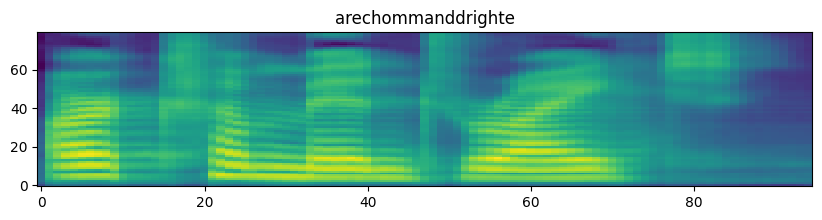

In [634]:
# plot predicted mel spectrogram
w = list(respelling2mel.keys())[0]
mel = respelling2mel[w]

print(w)
plot_melspec(mel, w)

preventing__LJ005-0279__occ1__len8480
mel.max()=-1.0421886, mel.min()=-11.512925


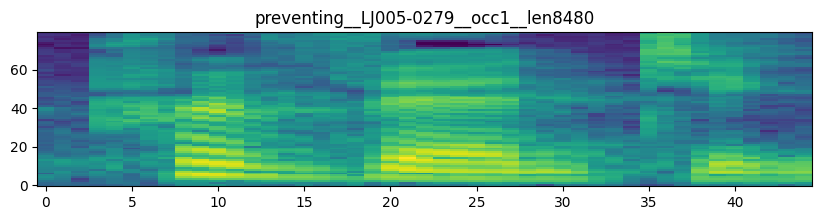

In [635]:
# plot GT mel spectrogram
token_id = list(token_id2fastpitch_gt_mel.keys())[0]
gt_mel = token_id2fastpitch_gt_mel[token_id]

print(token_id)
plot_melspec(gt_mel, token_id)

# convert mel spec to Mel-Cepstrum then plot

In [636]:
def plot_mfcc(mfcc, extra_title=""):
    # assume mfcc is a numpy array of shape (n_mfcc, n_frames)
    plt.figure(figsize=(10, 4))
    plt.imshow(mfcc, aspect='auto', origin='lower', cmap='coolwarm')
    plt.xlabel('Time')
    plt.ylabel('MFCC')
    title = 'MFCC'
    if extra_title:
        title += f": {extra_title}"
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

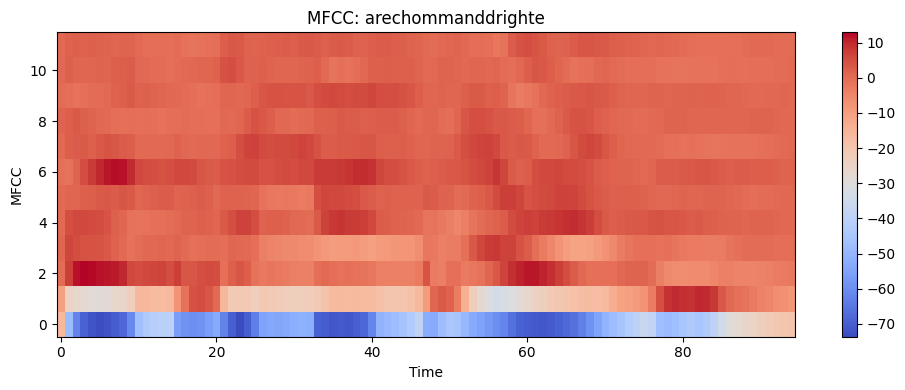

In [637]:
mfcc = melspec2mfcc(mel)
plot_mfcc(mfcc, w)

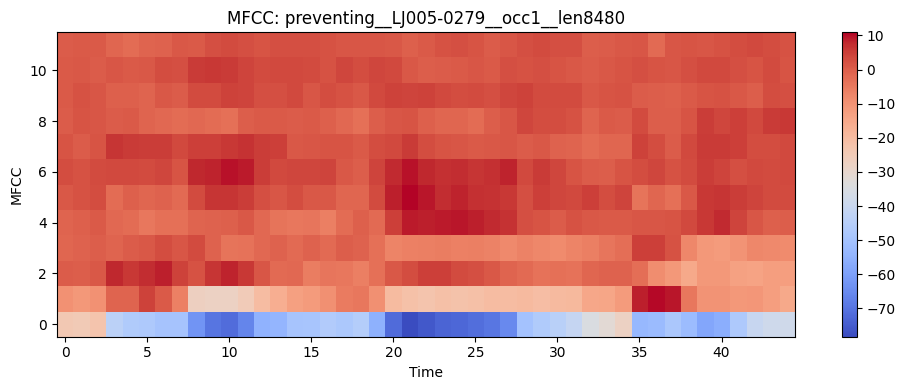

In [638]:
gt_mfcc = melspec2mfcc(gt_mel)
plot_mfcc(gt_mfcc, token_id)

# examine if mean-normalisation of MFCCs helps

In [639]:
mfcc.shape

(12, 95)

In [640]:
combined_mfcc = np.concatenate([mfcc, gt_mfcc], axis=1)

In [641]:
combined_mfcc.shape

(12, 140)

In [642]:
mean = np.mean(combined_mfcc, axis=1)[:, np.newaxis]

In [643]:
mean.shape

(12, 1)

In [644]:
mean

array([[-52.249966  ],
       [-13.446722  ],
       [  0.19554345],
       [ -2.6557024 ],
       [  2.2550616 ],
       [  2.379927  ],
       [  4.37962   ],
       [  2.2340238 ],
       [  1.0569876 ],
       [  1.8514241 ],
       [  1.1325489 ],
       [  1.15041   ]], dtype=float32)

In [645]:
normed_mfcc = mfcc - mean
normed_gt_mfcc = gt_mfcc - mean

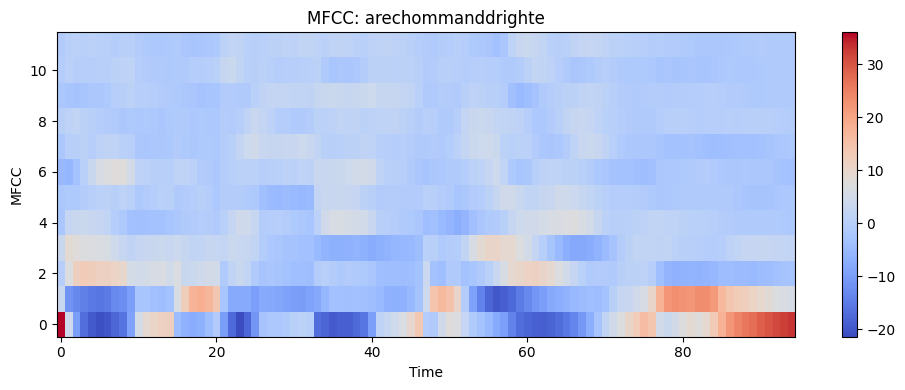

In [646]:
plot_mfcc(normed_mfcc, w)

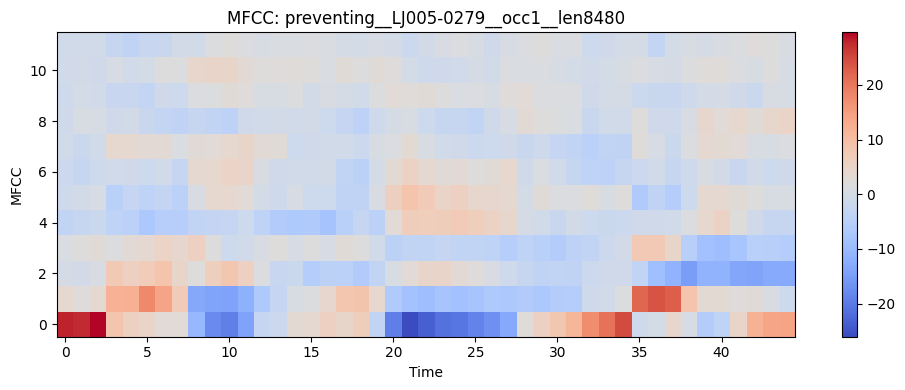

In [647]:
plot_mfcc(normed_gt_mfcc, token_id)

# add acoustic distances between ground truth audio for word and synthesised respellings

compare ranking by:
- MCD-DTW
- SoftDTW
- L1, L2 distance

In [648]:
import mcd
from mcd import dtw

def eucCost(x, y):
    """AKA l2 norm"""
    return math.sqrt(np.inner(x - y, x - y))

def manCost(x, y):
    """AKA l1 norm"""
    return np.sum(np.inner(x - y, x - y))

metric_registry = {
}

metric_type = "mcd_dtw"

distance_registry = {
    "euclidean": eucCost,
    "manhattan": manCost,
}

distance_type = "euclidean"

In [ ]:
# calculate MCD-DTW distance for each synthesised respelling in the dataframe
# to the gt mfcc for the token_id that the respelling was generated from (using ASR)
print(f"calculating MCD-DTW distances between GT and predicted mels using {distance_type}")
for row_idx in tqdm(df.index):
    respelling_mfcc = respelling2mfcc[df.loc[row_idx, 'respelling']]
    gt_mfcc = token_id2fastpitch_gt_mfcc[df.loc[row_idx, 'token_id']]
    respelling_mfcc = respelling_mfcc.T
    gt_mfcc = gt_mfcc.T
    distance_score, _path = dtw.dtw(gt_mfcc, respelling_mfcc, distance_registry[distance_type])
    df.loc[row_idx, f'mcd_dtw ({distance_type})'] = distance_score

calculating MCD-DTW distances between GT and predicted mels using euclidean


 57%|███████████████████████████▎                    | 9985/17584 [06:55<04:35, 27.57it/s]

In [ ]:
# sort df by distance then spelling
df = df.sort_values(['wordtype', 'mcd_dtw (euclidean)'])

# play audios for each word, ranked by certain metric (e.g. CER, acoustic distance, etc.)

In [ ]:
df["wordtype"].unique()

In [ ]:
# optionally only display a subset of the words

words_to_include = None # include all words
# words_to_include = [
#     "tradescantia",
#     "reinvigorated",
#     "orientgesellschaft",
#     "nebuchadrezzar",
#     "inefficacious",
# ]

if words_to_include is not None:
    filtered_df = pd.DataFrame()
    for wordtype in words_to_include:
        filtered_df = pd.concat([filtered_df, df.loc[df["wordtype"] == wordtype]]) 
else:
    filtered_df = df

In [ ]:
# get original spellings
original_spellings_mask = filtered_df['wordtype'] == filtered_df['respelling']
original_spellings_df = filtered_df[original_spellings_mask]

In [ ]:
# Optionally only display N-best ranked respellings per original input audio
# NB - exclude original spellings!
get_smallest = True
if get_smallest:
    lambda_fn = lambda x: x.nsmallest(n_spellings_per_token_id, 'mcd_dtw (euclidean)')
else:
    lambda_fn = lambda x: x.nlargest(n_spellings_per_token_id, 'mcd_dtw (euclidean)')
    
n_spellings_per_token_id = 5
mask = filtered_df['wordtype'] == filtered_df['respelling']
inverted_mask = ~mask
no_orig_spellings_df = filtered_df[inverted_mask]
filtered_df = no_orig_spellings_df.groupby('token_id').apply(lambda_fn)

In [ ]:
# add back original spellings
filtered_df = pd.concat([filtered_df, original_spellings_df], ignore_index=True)
filtered_df = filtered_df.groupby('token_id').apply(lambda x: x.sort_values('mcd_dtw (euclidean)'))

In [ ]:
# add column to indicate whether it is original spelling or not
new_col_idx = 1 + filtered_df.columns.get_loc('respelling') # insert after respelling column
filtered_df.insert(new_col_idx, 'is_orig', filtered_df['wordtype'] == filtered_df['respelling'])

In [ ]:
filtered_df

In [ ]:
# TODO show audios in table (follow https://stackoverflow.com/questions/52547769/how-can-i-layout-a-list-of-ipython-display-audio-objects-in-a-jupyter-notebook ) 
# respelling audio, gt recording, original spelling audio
current_wordtype = ""
for token_id, wordtype, respelling, distance, orig_wav in zip(filtered_df['token_id'], 
                                                              filtered_df['wordtype'], 
                                                              filtered_df['respelling'], 
                                                              filtered_df['mcd_dtw (euclidean)'], 
                                                              filtered_df['orig_wav']):
    if current_wordtype != wordtype:
        print("\n===============================================================")

        current_wordtype = wordtype
        
        print(f"====== Original word aligned WAV ({token_id=}):")
        display(Audio(orig_wav, rate=16000))
        print("===============================================================")
        
    # print_str = f"original='{wordtype}'"
    print_str = ""
    if wordtype != respelling:
        print_str += f" ---> {respelling=}"
    else:
        print_str += f"{' '+wordtype+' ':*^35}"
    distance_str = f" {distance:.2f} ({metric_type}, {distance_type})"
    print_str += distance_str
    
    print(print_str)
    display(Audio(respelling2audio[respelling], rate=22050))